# Project week 7

For the project this week, you are given a video of a ball rolling over a surface. Your job is now to detect the ball, track the position, velocity and acceleration using a Kalman filter, and finally draw the currently tracked position and predicted position of the ball in the images, while also printing the whole predicted state in either the image or the terminal.

The video "rolling_ball_result.mp4" shows what the end result could look like.

You have to make the Kalman filter yourselves, i.e. initialize the matrices and make a update and predict function. You are of course allowed to use numpy.

You can use the code below and fill in the missing parts.



In [1]:
import cv2
import numpy as np
import pdb
import math

#pdb.set_trace()
def update(x, P, Z, H, R):
    ### Insert update function
    y = Z-np.dot(H, x)
    S = np.dot(np.dot(H, P),np.transpose(H))+R
    K = np.dot(np.dot(P, np.transpose(H)),np.linalg.pinv(S))
    x = x+np.dot(K, y)
    P = np.dot((I-np.dot(K, H)),P)
    return x, P

def predict(x, P, F, u):
    ### insert predict function
    x = np.dot(F, x)+u
    P = np.dot(np.dot(F, P),np.transpose(F))
    return x, P
    
### Initialize Kalman filter ###
# The initial state (6x1).
# displacement, velocity, acceleration
# including x, v_x, a_x, y, v_y, a_y 
X = np.array([[0], [0], [0], [0], [0], [0]])

# The initial uncertainty (6x6).
# let's assume a large initial value since at the very first the uncertainty is high
# we know nothing
uc = 1000
P = np.array([[uc, 0, 0, 0, 0, 0],[0, uc, 0, 0, 0, 0],[0, 0, uc, 0, 0, 0],[0, 0, 0, uc, 0, 0],[0, 0, 0, 0, uc, 0],[0, 0, 0, 0, 0, uc]])

# The external motion (6x1).
u = np.array([[0],[0],[0],[0],[0],[0]])

# The transition matrix (6x6). 
F = np.array([[1, 1, 0.5, 0, 0, 0],
              [0, 1, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 1, 0.5],
              [0, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 0, 1]])

# The observation matrix (2x6).
H = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

# The measurement uncertainty.
R = np.array([[1],[1]])

I = np.diag([1,1,1,1,1,1])

# Load the video
cap = cv2.VideoCapture('rolling_ball.mp4')
if not cap.isOpened():
    print("Cannot open video")
    exit()


# Looping through all the frames
v = None
while True:
    ret, frame = cap.read()
    if not ret:
        break
    ### Detect the ball ###
    # Equal to Measurement
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # extract color, the ball is red
    mask = cv2.inRange(frame, np.array([10, 10, 95]), np.array([80, 80, 255]))
    gray = gray*mask
    # Canny edge detection
    edges = cv2.Canny(gray, 50, 60)
    # Hough transform
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 50, param1=60, param2=20, minRadius=65, maxRadius=80)
    #print(circles)
    if circles is not None:
        circles = circles[0]
        for c in range(len(circles)):
            x = np.int(circles[c][0])
            y = np.int(circles[c][1])
        cv2.circle(frame, (x, y), 80, (0, 0, 255), 5)
        z = np.array([[x],[y]]) 
        # measurement value
        ### If the ball is found, update the Kalman filter ###
        # now we have the measurement (x,y)
        # measurement update based on measurement model
        # Bayes Rule
        X, P = update(X, P, z, H, R)
        v = [X[1],X[4]]
    else:
        if v is not None:
            # let's assume that when the object is hiden, it will remain the former motion
            #X[1] = v[0]
            #X[4] = v[1]
            #uc = 1000
            #P = np.array([[uc, 0, 0, 0, 0, 0],[0, uc, 0, 0, 0, 0],[0, 0, uc, 0, 0, 0],[0, 0, 0, uc, 0, 0],[0, 0, 0, 0, uc, 0],[0, 0, 0, 0, 0, uc]])
            pass
        cv2.circle(frame, (X[0], X[3]), 80, (0, 0, 255), 5)
    ### Predict the next state
    # action update(predict) based on motion model
    # Total Probability Theorem
    X, P = predict(X, P, F, u)
    ### Draw the current tracked state and the predicted state on the image frame ###
    cv2.circle(frame, (X[0], X[3]), 80, (255, 0, 0), 5)
    # Show the frame
    cv2.namedWindow('Frame',0)
    cv2.resizeWindow('Frame',800, 500)
    cv2.imshow('Frame', frame)
    cv2.waitKey(50)
    
cap.release()
cv2.destroyAllWindows()

Try showing the video "rolling_ball_result.mp4" instead, to see what the end result could look like.

## Hints

The first part is to detect the ball. For this part you can look back to the exercises from week 2. More specifically the end of exercise 1. You may have to adjust some parameters in order to only detect the ball.

The next part is to make the Kalman filter. If you did the exercises from monday this week, you already have a suitable update and predict function. You will have to initialize all the different matrices, which we also did in the exercises, however this time we would like the state to include position, velocity and acceleration in both the x- and y-direction (6 states).

Start by defining your state **x** and uncertainty **P**. Then define a transition matrix **F** based on your state. When defining the state transition last time we used the equation for linear motion:

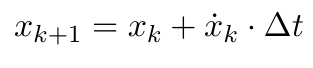

We used dt = 1 (delta t), for simplicity. You can do the same here. However, this time we also have the acceleration and therefore we use:

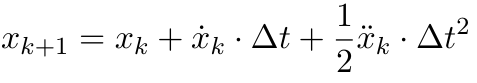

Finally, for a part of the video, the ball is behind something and can't be seen. Obviously we cant update our state here, because there is no measurement. So when there is no measurements available, you should only use the predict function and not the update function, to estimate the state.


# Challenge

If you can't get enough of tracking and Kalman filters, try extending your program, such that it can keep track of multiple balls at the same time. Use the video "rolling_ball_challenge.mp4" to test it. You can take advantage of the balls having different colours.

In [2]:
# Now we have 2 balls
import cv2
import numpy as np
import pdb
import math

def update(x, P, Z, H, R):
    ### Insert update function
    y = Z-np.dot(H, x)
    S = np.dot(np.dot(H, P),np.transpose(H))+R
    K = np.dot(np.dot(P, np.transpose(H)),np.linalg.pinv(S))
    x = x+np.dot(K, y)
    P = np.dot((I-np.dot(K, H)),P)
    return x, P

def predict(x, P, F, u):
    ### insert predict function
    x = np.dot(F, x)+u
    P = np.dot(np.dot(F, P),np.transpose(F))
    return x, P

def kalmanTrack(frame, lowThr, uppThr, color, X, P, v):
    ### Detect the ball ###
    # Equal to Measurement
    gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
    # extract color, the ball is red
    mask = cv2.inRange(frame, lowThr, uppThr)
    gray = gray*mask
    # Canny edge detection
    edges = cv2.Canny(gray, 50, 60)
    #cv2.namedWindow('gray',0)
    #cv2.resizeWindow('gray',800, 500)
    #cv2.imshow('gray', gray)
    #cv2.waitKey(50)
    # Hough transform
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1, 50, param1=60, param2=10, minRadius=70, maxRadius=80)
    if circles is not None:
        circles = circles[0]
        for c in range(len(circles)):
            x = np.int(circles[c][0])
            y = np.int(circles[c][1])
        cv2.circle(frame, (x, y), 80, color, 5)
        z = np.array([[x],[y]]) 
        # measurement value
        ### If the ball is found, update the Kalman filter ###
        # now we have the measurement (x,y)
        # measurement update based on measurement model
        # Bayes Rule
        X, P = update(X, P, z, H, R)
        v = [X[1],X[4]]
    else:
        if v is not None:
            # let's assume that when the object is hiden, it will remain the former motion
            X[1] = v[0]
            X[4] = v[1]
            uc = 1000
            P = np.array([[uc, 0, 0, 0, 0, 0],[0, uc, 0, 0, 0, 0],[0, 0, uc, 0, 0, 0],[0, 0, 0, uc, 0, 0],[0, 0, 0, 0, uc, 0],[0, 0, 0, 0, 0, uc]])
        cv2.circle(frame, (X[0], X[3]), 80, color, 5)
    ### Predict the next state
    # action update(predict) based on motion model
    # Total Probability Theorem
    XX, PP = predict(X, P, F, u)
    ### Draw the current tracked state and the predicted state on the image frame ###
    w,l,k = frame.shape
    if X[0]<-40 or X[0]>l+40 or X[3]<-40 or X[3]>w+40:
        X[1] = 0
        X[4] = 0
        uc = 1000
        P = np.array([[uc, 0, 0, 0, 0, 0],[0, uc, 0, 0, 0, 0],[0, 0, uc, 0, 0, 0],[0, 0, 0, uc, 0, 0],[0, 0, 0, 0, uc, 0],[0, 0, 0, 0, 0, uc]])
        XX, PP = predict(X, P, F, u)
    return XX, PP, v
    
### Initialize Kalman filter ###
# The initial state (6x1).
X1 = np.array([[0], [0], [0], [0], [0], [0]])
X2 = np.array([[0], [0], [0], [0], [0], [0]])

# The initial uncertainty (6x6).
# let's assume a large initial value since at the very first the uncertainty is high
# we know nothing
uc = 1000
P1 = np.array([[uc, 0, 0, 0, 0, 0],[0, uc, 0, 0, 0, 0],[0, 0, uc, 0, 0, 0],[0, 0, 0, uc, 0, 0],[0, 0, 0, 0, uc, 0],[0, 0, 0, 0, 0, uc]])
P2 = np.array([[uc, 0, 0, 0, 0, 0],[0, uc, 0, 0, 0, 0],[0, 0, uc, 0, 0, 0],[0, 0, 0, uc, 0, 0],[0, 0, 0, 0, uc, 0],[0, 0, 0, 0, 0, uc]])

# The external motion (6x1).
u = np.array([[0],[0],[0],[0],[0],[0]])


# The transition matrix (6x6). 
F = np.array([[1, 1, 0.5, 0, 0, 0],
              [0, 1, 1, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 1, 1, 0.5],
              [0, 0, 0, 0, 1, 1],
              [0, 0, 0, 0, 0, 1]])

# The observation matrix (2x6).
H = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])

# The measurement uncertainty.
R = np.array([[1],[1]])

I = np.diag([1,1,1,1,1,1])

lowThr1 = np.array([10, 10, 120])
uppThr1 = np.array([70, 70, 255])
lowThr2 = np.array([0, 100, 100])
uppThr2 = np.array([10, 255, 255])

# Load the video
cap = cv2.VideoCapture('rolling_ball_challenge.mp4')
if not cap.isOpened():
    print("Cannot open video")
    exit()


# Looping through all the frames
v1 = None
v2 = None

while True:
    ret, frame = cap.read()
    if not ret:
        break
    X1, P1, v1 = kalmanTrack(frame, lowThr1, uppThr1, (0,0,255), X1, P1, v1)
    X2, P2, v2 = kalmanTrack(frame, lowThr2, uppThr2, (0,255,255), X2, P2, v2)
    cv2.circle(frame, (X1[0], X1[3]), 80, (255, 0, 0), 5)
    cv2.circle(frame, (X2[0], X2[3]), 80, (0, 255, 0), 5)
    # Show the frame
    cv2.namedWindow('Frame',0)
    cv2.resizeWindow('Frame',800, 500)
    cv2.imshow('Frame', frame)
    cv2.waitKey(50)
    
cap.release()
cv2.destroyAllWindows()

KeyboardInterrupt: 